# **Import libs**

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import torchvision.transforms as transforms

# **Data collection**

download data as <a href="https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.kaggle.com/datasets/abhikjha/utk-face-cropped&ved=2ahUKEwjv4tiruuuKAxWZ87sIHeg-OjcQFnoECBYQAQ&usg=AOvVaw0vrJa6KzDcoST2A01p3UVY">UTK face</a> and save in /data/raw/

In [28]:
dataset_folder = '../data/raw/'
image_files = os.listdir(dataset_folder)
image_files[:5]

['100_0_0_20170112213500903.jpg.chip.jpg',
 '100_0_0_20170112215240346.jpg.chip.jpg',
 '100_1_0_20170110183726390.jpg.chip.jpg',
 '100_1_0_20170112213001988.jpg.chip.jpg',
 '100_1_0_20170112213303693.jpg.chip.jpg']

The labels of each face image is embedded in the file name, formated like:

**[age] _ [gender] _ [race] _ [date&time].jpg**

- [age] is an integer from 0 to 116, indicating the age
- [gender] is either 0 (male) or 1 (female)
- [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace


In [37]:
race_map = {
    '0': 'White',
    '1': 'Black',
    '2': 'Asian',
    '3': 'Indian',
    '4': 'Others'
}

df = pd.DataFrame(columns=['image_name', 'age', 'race', 'gender'])
for img in image_files:
    data = img.split('_')
    
    if len(data) != 4:
        continue
    
    age = int(data[0])
    if age > 80:
        continue
    
    gender = 'Male' if data[1] == '0' else 'Female'
    race = race_map[data[2]]
    
    record = [img, age, race, gender]
    df.loc[len(df)] = record
    
df.head()

,image_name,age,race,gender
0,10_0_0_20161220222308131.jpg.chip.jpg,10,White,Male
1,10_0_0_20170103200329407.jpg.chip.jpg,10,White,Male
2,10_0_0_20170103200522151.jpg.chip.jpg,10,White,Male
3,10_0_0_20170103233459275.jpg.chip.jpg,10,White,Male
4,10_0_0_20170104013211746.jpg.chip.jpg,10,White,Male


In [38]:
df.to_csv('../data/preprocess/utkface_dataset.csv', index=False)

# **Explore in data**

In [31]:
df = pd.read_csv('../data/preprocess/utkface_dataset.csv')

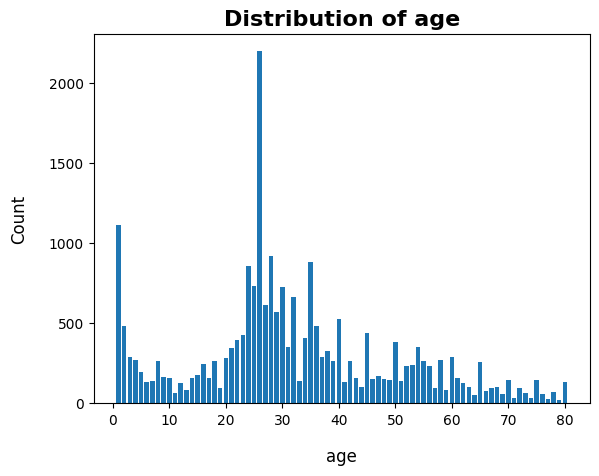

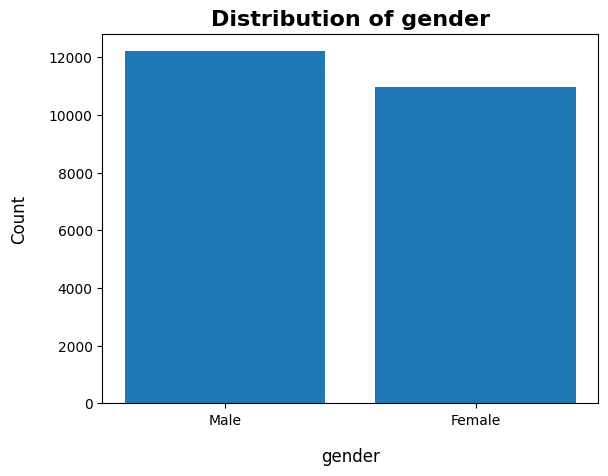

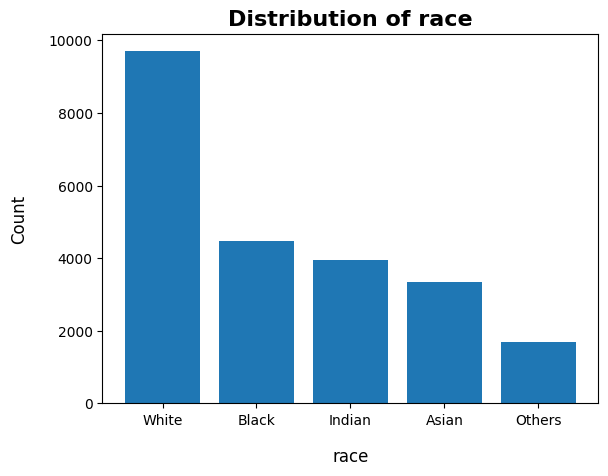

In [55]:
for field in ['age', 'gender', 'race']:
    data = df[field].value_counts()
    plt.title(f'Distribution of {field}', fontsize=16, fontweight='bold')
    plt.bar(data.index, data.values)
    plt.xlabel(field, fontsize=12, labelpad=15)
    plt.ylabel('Count', fontsize=12, labelpad=15)
    plt.show()

In [43]:
pd.crosstab(index=df['gender'], columns=df['race'], normalize='all') * 100

race,Asian,Black,Indian,Others,White
gender,,,,,
Female,7.816886,9.423451,7.333189,4.016411,18.721658
Male,6.629238,9.915785,9.734399,3.269272,23.139711


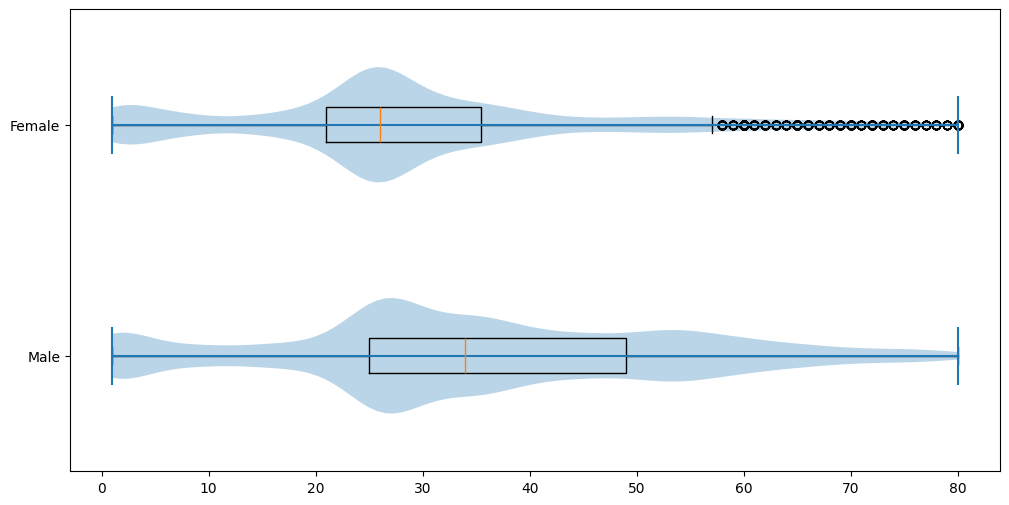

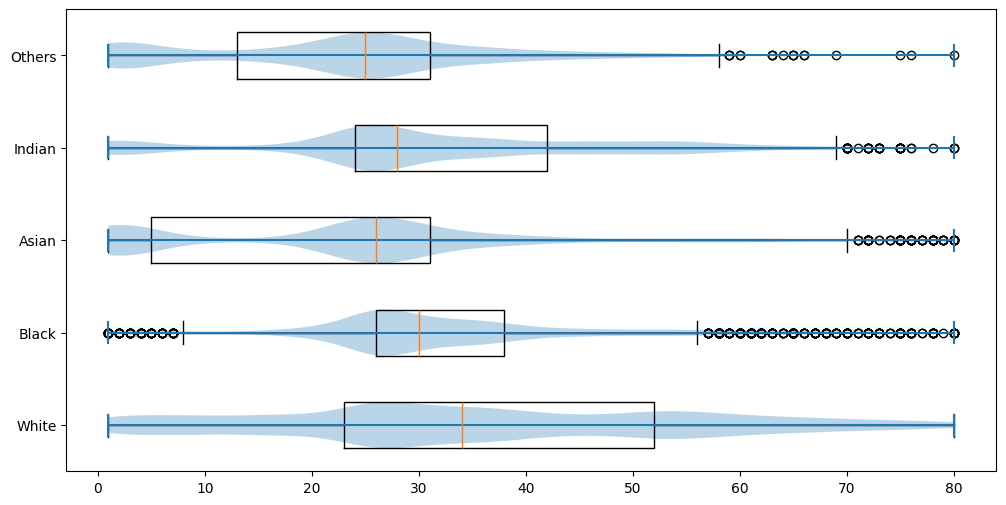

In [54]:
for field in ['gender', 'race']:
    plt.figure(figsize=(12, 6))
    plt.boxplot([df['age'][df[field] == cat] for cat in df[field].unique()], vert=False, tick_labels=df[field].unique())
    plt.violinplot([df['age'][df[field] == cat] for cat in df[field].unique()], vert=False)
    plt.show()

# **Split data**

In [4]:
df = pd.read_csv('../data/preprocess/utkface_dataset.csv')
df = df[['image_name', 'age']]

In [5]:
df_train, df_temp = train_test_split(df, stratify=df['age'], shuffle=True, test_size=0.3, random_state=42)
df_test, df_valid = train_test_split(df_temp, stratify=df_temp['age'], shuffle=True, test_size=0.5, random_state=42)
del df_temp

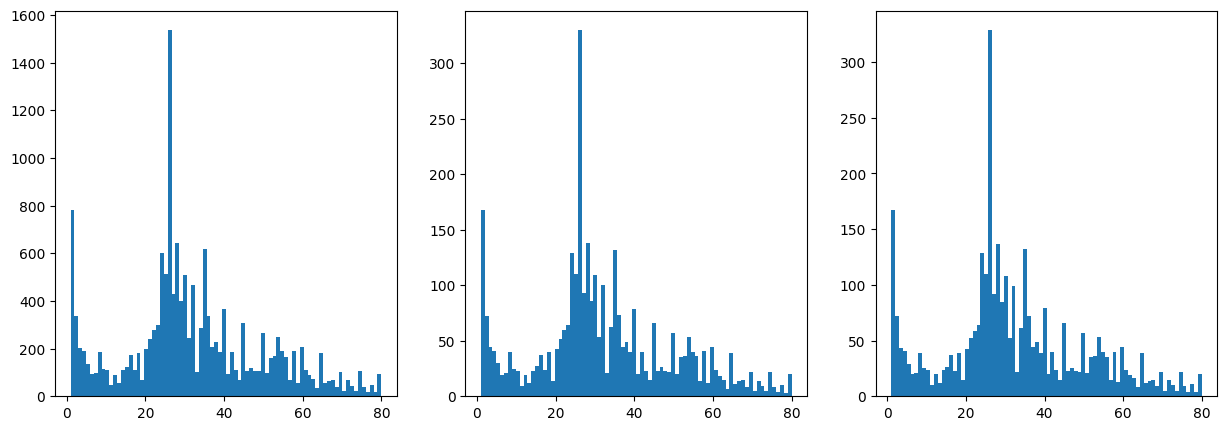

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, dataset in enumerate([df_train, df_valid, df_test]):
    ax[i].hist(dataset['age'], bins=80)
plt.show()

In [7]:
df_train.to_csv('../data/preprocess/train.csv', index=False)
df_valid.to_csv('../data/preprocess/valid.csv', index=False)
df_test.to_csv('../data/preprocess/test.csv', index=False)

# **Transformation**

In [13]:
train_transformation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transformation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **Custom dataset**

In [69]:
class UTKDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        path = os.path.join(self.root_dir, item['image_name'])
        image = Image.open(path)
        if self.transform is not None:
            image = self.transform(image)
        age = torch.tensor(item['age'], dtype=torch.float32)
        return image, age

In [70]:
root_dir = 'data/raw/'
train_dataset = UTKDataset(root_dir, '../data/preprocess/train.csv', train_transformation)
valid_dataset = UTKDataset(root_dir, '../data/preprocess/valid.csv', test_transformation)
test_dataset = UTKDataset(root_dir, '../data/preprocess/test.csv', test_transformation)

# **Data loader**

In [72]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)